# Notebook overview

Run the Deep Dream generative image filter with slight modifications. Original code from [here](https://www.tensorflow.org/tutorials/generative/deepdream).

# Images

Images downloaded from the [National Gallery of Art](https://www.nga.gov/) website (Creative Commons Zero license). The base [image](https://www.nga.gov/collection/art-object-page.46580.html) of "rococo flowers" is called "Flowers in a Rococo Vase" by French artist Paul Cézanne. 

In [17]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image


In [18]:
url = "https://media.nga.gov/iiif/0aa7a4e2-0231-4bb2-9f8a-90e754c58807/full/full/0/default.jpg?attachment_filename=flowers_in_a_rococo_vase_1963.10.105.jpg"

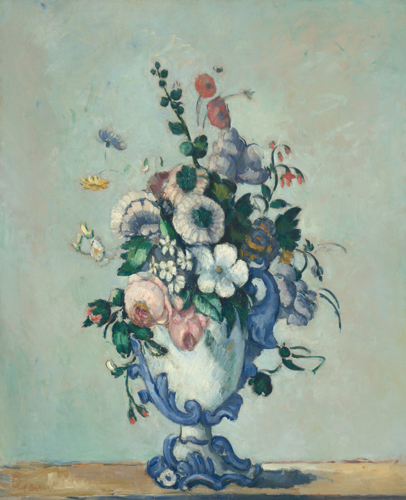

In [19]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [20]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')


In [22]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


In [23]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)


In [24]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [25]:
deepdream = DeepDream(dream_model)


In [26]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

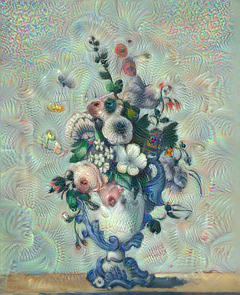

KeyboardInterrupt: ignored

In [10]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

In [27]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

In [28]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [29]:
get_tiled_gradients = TiledGradients(dream_model)


In [30]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, 
                                seednum = 1, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  random.seed(seednum)
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        imgiter = PIL.Image.fromarray(np.array(deprocess(img)))
        imgiter.save("rococo-flowers_step"+str(step)+"_seed"+str(seednum)+".jpg")
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

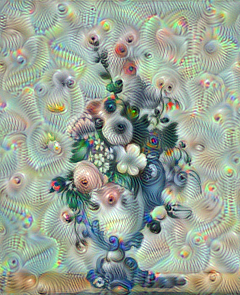

Octave -2, Step 90


KeyboardInterrupt: ignored

In [ ]:
import random
seednum = 1
img = run_deep_dream_with_octaves(img=original_img, 
                                  step_size=0.01, 
                                  seednum = seednum)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)
